#Using SD models to understand the differences between population measures at varying levels of geographic disagregation 
In this recipe, we will use data at a national level to infer parameters for a population aging model. We'll then try two different ways of using this trained model to understand variation between the behavior of each of the states. 


## About this technique
Firstly, we'll use the parameters fit at the national level to predict census data at the disaggregated level, and compare these predicted state-level outputs with the measured values. This gives us a sense for how different the populations of the states are from what we should expect given our understanding of the national picture.

Secondly, we'll fit parameters to a model at each of the state levels actual measured census data, and then compare the differences in fit parameters to each other and to the national expectation. This is a helpful analysis if the parameter itself (and its inter-state variance) is what we find interesting.

In [1]:
%pylab inline
import pandas as pd
import pysd
import scipy.optimize
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


##Ingredients

### Population data by age cohort
We start with data from the decennial census years 2000 and 2010, for the male population by state and county. We have aggregated the data into ten-year age cohorts (with the last cohort representing everyone over 80 years old). The data collection task is described [here](data/Census/US Census Data Collection.ipynb). In this analysis we will only use data at the state and national levels.

In [2]:
data = pd.read_csv('../../data/Census/Males by decade and county.csv', header=[0,1], index_col=[0,1])
data.head()

2000                                                     2010  \
             dec_1  dec_2 dec_3 dec_4  dec_5 dec_6 dec_7 dec_8 dec_9  dec_1   
state county                                                                  
1     1       3375   3630  2461  3407   3283  2319  1637   825   284   3867   
      3       9323  10094  7600  9725  10379  8519  6675  4711  1822  11446   
      5       2002   2198  2412  2465   2178  1699  1026   689   301   1673   
      7       1546   1460  1680  1762   1624  1237   774   475   187   1471   
      9       3741   3615  3393  3901   3773  3007  2227  1269   550   3741   

                                                                   
              dec_2 dec_3  dec_4  dec_5  dec_6  dec_7 dec_8 dec_9  
state county                                                       
1     1        4384  3082   3598   4148   3390   2293  1353   454  
      3       12006  9976  11042  12517  12368  10623  6307  2911  
      5        1739  2260   2208   2233   1910   1490   739   324  
      7        1577  1798   2016   1928   1581   1140   579   211  
      9        4252  3312   3719   4129   3782   3052  1723   652

###A model of an aging population

The model we'll use to represent the population is a simple aging chain, with individuals aggregated into stocks by decade, to match the agregation we used for the above data. Each cohort is promoted with a timescale of 10 years, and there is some net inmigration, outmigration, and death subsumed into the `loss` flow associated with each cohort. This loss is controled by some yearly fraction that it will be our task to understand. 

<img src="../../models/Aging_Chain/Aging_Chain.png" alt="Still Image of Vensim Aging Chain Model" style="width: 600px;"/>

In [3]:
model = pysd.read_vensim('../../models/Aging_Chain/Aging_Chain.mdl')

Our model is initialy parameterized with 10 individuals in each stock, no births, and a uniform loss rate of 5%. We'll use data to set the initial conditions, and infer the loss rates. Estimating births is difficult, and so for this analysis, we'll pay attention only to individuals who have been born before the year 2000.

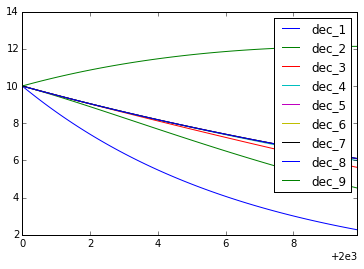

In [4]:
model.run().plot();

### Geography Information

This information comes to us as a shape file `.shp` with its associated `.dbf` and `.shx` conspirator files. Lets check the plotting functionality:

,CensusDiv,CensusReg,FIPS,FIPSNum,Notes,OBJECTID,StateFIPS,StateName,XCentroid,YCentroid,geometry
StateFIPSN,,,,,,,,,,,
2,Pacific,West,02000,2000,None,1,02,Alaska,-1882092.15195,2310348.392810,(POLYGON ((-2247528.774479387 2237995.01157197...
53,Pacific,West,53000,53000,None,9,53,Washington,-1837353.15317,1340481.223852,(POLYGON ((-2124362.24278068 1480441.850674443...


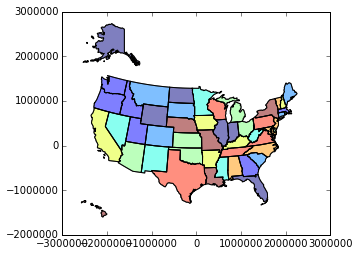

In [5]:
state_geo = gpd.read_file('../../data/Census/US_State.shp')
state_geo.set_index('StateFIPSN', inplace=True)
state_geo.plot();
state_geo.head(2)

## Recipe Part A: Predict state-level values from national model fit

### Step 1: Initialize the model using census data

We can aggregate the county level data to the national scale by summing across all geographies. This is relatively straightforward.

In [6]:
country = data.sum()
country

2000  dec_1    20332536
      dec_2    20909490
      dec_3    19485544
      dec_4    21638975
      dec_5    21016627
      dec_6    15115009
      dec_7     9536197
      dec_8     6946906
      dec_9     3060483
2010  dec_1    20703935
      dec_2    21878666
      dec_3    21645336
      dec_4    20033352
      dec_5    21597437
      dec_6    20451686
      dec_7    13926846
      dec_8     7424945
      dec_9     4083435
dtype: float64

If we run the model using national data from the year 2000 as starting conditions, we can see how the cohorts develop, given our arbitrary loss rate values:

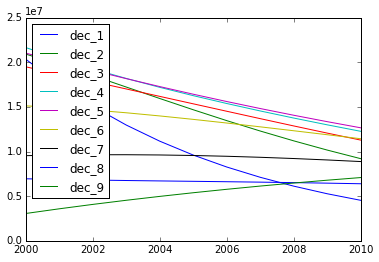

In [7]:
model.run(return_timestamps=range(2000,2011), 
          initial_condition=(2000, country['2000'])).plot();

### Step 2: Fit the national level model to the remaining data
We've used half of our data (from the year 2000 census) to initialize our model. Now we'll use an optimization routine to choose the loss rate parameters that best predict the census 2010 data. We'll use the same basic operations described in the previous recipe: [Fitting with Optimization](2_1_Fitting_with_Optimization.ipynb).

To make this simple, we'll write a function that takes a list of potential model parameters, and returns the model's prediction in the year 2010


In [8]:
def exec_model(paramlist):
    params = dict(zip(['dec_%i_loss_rate'%i for i in range(1,10)], paramlist)) 
    output = model.run(initial_condition=(2000,country['2000']),
                       params=params, return_timestamps=2010)
    return output

Now we'll define an error function that calls this executor and calculates a sum of squared errors value. Remember that because we don't have birth information, we'll only calculate error based upon age cohorts 2 through 9.

In [9]:
def error(paramlist):
    output = exec_model(paramlist)
    errors = output - country['2010']
    #don't tally errors in the first cohort, as we don't have info about births
    return sum(errors.values[0,1:]**2)

Now we can use the minimize function from scipy to find a vector of parameters which brings the 2010 predictions into alignment with the data.

In [10]:
res = scipy.optimize.minimize(error, x0=[.05]*9,
                              method='L-BFGS-B')
country_level_fit_params = dict(zip(['dec_%i_loss_rate'%i for i in range(1,10)], res['x']))
country_level_fit_params

{'dec_1_loss_rate': 0.021183432598200467,
 'dec_2_loss_rate': -0.052101419562612286,
 'dec_3_loss_rate': -0.0014091019293939956,
 'dec_4_loss_rate': 0.0088436979759478375,
 'dec_5_loss_rate': -0.0072046351581388701,
 'dec_6_loss_rate': -0.011046250905098235,
 'dec_7_loss_rate': 0.017228650364514753,
 'dec_8_loss_rate': 0.063195268137886118,
 'dec_9_loss_rate': 0.16077452197707129}

If we run the national model forwards with these parameters, we see generally good behavior, except for the 0-9yr demographic bracket, from whom we expect less self-control. (And because we don't have births data.)

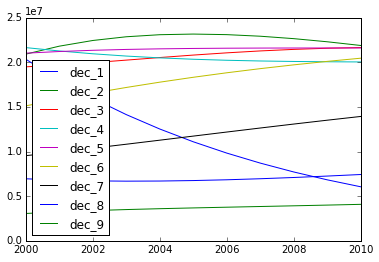

In [11]:
model.run(params=country_level_fit_params,
          return_timestamps=range(2000,2011), 
          initial_condition=(2000, country['2000'])).plot();

###Step 3: Make state-level predictions

If we want to look at the variances between the states and the national level, we can try making state-level predictions using state-specific initial conditions, but parameters fit at the national level.

In [12]:
states = data.sum(level=0)
states.head()

2000                                                                \
         dec_1    dec_2    dec_3    dec_4    dec_5    dec_6    dec_7   dec_8   
state                                                                          
1       312841   329043   301076   315262   321447   246427   165327  109918   
2        50687    53992    42537    51442    56047    35804    14974    7628   
4       395110   384672   386486   391330   352471   257798   187193  144837   
5       188589   201405   180801   187516   186931   149142   104621   72629   
6      2669364  2588761  2556975  2812648  2495158  1692007  1002881  725610   

                  2010                                                        \
        dec_9    dec_1    dec_2    dec_3    dec_4    dec_5    dec_6    dec_7   
state                                                                          
1       45131   312605   338568   321236   297502   321810   318358   229496   
2        2325    53034    52278    58166    47753    51856    54170    29869   
4       61148   463808   466275   455170   422447   418398   381076   300553   
5       33050   201821   205074   196956   183761   192596   188081   143285   
6      331342  2573619  2780997  2849483  2595717  2655307  2336519  1489395   

                       
        dec_8   dec_9  
state                  
1      124070   56543  
2       10392    4151  
4      178849   89247  
5       81138   38925  
6      780576  456217

We can now generate a prediction by setting the model's intitial conditions with state level data, and parameters fit in the national case. I've created a `model_runner` helper function to make the code easier to read, but this could be conducted in a single line if we so chose.

In [13]:
def model_runner(row):
    result = model.run(params=country_level_fit_params, 
                       initial_condition=(2000,row['2000']), 
                       return_timestamps=2010)
    return result.loc[2010]
    
state_predictions = states.apply(model_runner, axis=1)
state_predictions.head()

,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
state,,,,,,,,,
1,93117.371881,341167.213342,337071.875334,304311.201330,325833.277920,316445.464900,223627.149408,121168.476612,65739.525962
2,15087.025659,55697.612356,52613.730625,47359.482364,53391.883377,50862.893499,31762.129879,14297.875847,6133.949764
4,117604.805785,411745.021973,413024.709292,377589.072369,386843.833461,354697.832262,246306.408711,138031.543558,79499.152922
5,56133.665931,207553.388634,204417.938099,183004.303895,192875.524445,187772.888790,135135.556656,75209.777699,42570.643627
6,794538.317812,2775504.193632,2765302.000982,2586476.416275,2709538.756509,2450307.128284,1595568.711162,818892.701581,439955.979351


### Step 4: Compare model predictions with measured data
Comparing the state level predictions with the actual data, we can see where our model most under or overpredicts population for each region/cohort combination.

In [14]:
diff = state_predictions-states['2010']
diff.head()

,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
state,,,,,,,,,
1,-219487.628119,2599.213342,15835.875334,6809.201330,4023.277920,-1912.535100,-5868.850592,-2901.523388,9196.525962
2,-37946.974341,3419.612356,-5552.269375,-393.517636,1535.883377,-3307.106501,1893.129879,3905.875847,1982.949764
4,-346203.194215,-54529.978027,-42145.290708,-44857.927631,-31554.166539,-26378.167738,-54246.591289,-40817.456442,-9747.847078
5,-145687.334069,2479.388634,7461.938099,-756.696105,279.524445,-308.111210,-8149.443344,-5928.222301,3645.643627
6,-1779080.682188,-5492.806368,-84180.999018,-9240.583725,54231.756509,113788.128284,106173.711162,38316.701581,-16261.020649


This is a little easier to understand if we weight it by the actual measured population:

In [15]:
diff_percent = (state_predictions-states['2010'])/states['2010']
diff_percent.head()

,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
state,,,,,,,,,
1,-0.702124,0.007677,0.049297,0.022888,0.012502,-0.006007,-0.025573,-0.023386,0.162647
2,-0.715522,0.065412,-0.095456,-0.008241,0.029618,-0.061051,0.063381,0.375854,0.477704
4,-0.746436,-0.116948,-0.092592,-0.106186,-0.075417,-0.069220,-0.180489,-0.228223,-0.109223
5,-0.721864,0.012090,0.037886,-0.004118,0.001451,-0.001638,-0.056876,-0.073063,0.093658
6,-0.691276,-0.001975,-0.029543,-0.003560,0.020424,0.048700,0.071286,0.049088,-0.035643


###Step 5: Merge with geo data to plot

I'm using geopandas to manage the shapefiles, and it has its own plotting functionality. Unfortunately, it is not a particularly well defined functionality.

,CensusDiv,CensusReg,FIPS,FIPSNum,Notes,OBJECTID,StateFIPS,StateName,XCentroid,YCentroid,geometry,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
StateFIPSN,,,,,,,,,,,,,,,,,,,,
2,Pacific,West,02000,2000,None,1,02,Alaska,-1882092.151950,2310348.392810,(POLYGON ((-2247528.774479387 2237995.01157197...,-0.715522,0.065412,-0.095456,-0.008241,0.029618,-0.061051,0.063381,0.375854,0.477704
53,Pacific,West,53000,53000,None,9,53,Washington,-1837353.153170,1340481.223852,(POLYGON ((-2124362.24278068 1480441.850674443...,-0.718560,-0.006548,-0.058893,-0.069401,-0.018494,-0.031807,-0.047478,0.013500,-0.030573
23,New England,Northeast,23000,23000,None,10,23,Maine,2068849.532637,1172786.748295,(POLYGON ((1951177.135094963 1127914.539498126...,-0.682708,0.073037,0.147467,0.085983,-0.023217,-0.055249,-0.076098,-0.034226,-0.009394
27,West North Central,Midwest,27000,27000,None,11,27,Minnesota,131047.575089,982130.006959,POLYGON ((-91052.16805501282 1282100.079225723...,-0.711546,0.062669,0.034611,0.032717,0.020127,-0.019902,0.043175,0.022524,-0.060437
26,East North Central,Midwest,26000,26000,None,18,26,Michigan,842567.889298,809437.260865,"(POLYGON ((764918.7306621727 786184.882347865,...",-0.657411,0.082088,0.197840,0.176409,0.088111,0.032552,0.050903,0.075986,0.011505


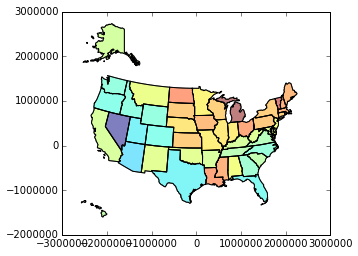

In [16]:
geo_diff = state_geo.join(diff_percent)
geo_diff.plot(column='dec_4')
geo_diff.head()

## Recipe Part B: fit state-by-state models

Now lets try optimizing the model's parameters specifically to each state, and comparing with the national picture. 

### Step 1: Write the optimization functions to account for the state
We'll start as before with functions that run the model and compute the error (this time with a parameter for the information about the state in question) and add a function to optimize and return the best fit parameters for each state.

In [17]:
def exec_model(paramlist, state):
    params = dict(zip(['dec_%i_loss_rate'%i for i in range(1,10)], paramlist)) 
    output = model.run(initial_condition=(2000,state['2000']),
                       params=params, return_timestamps=2010).loc[2010]
    return output

def error(paramlist, state):
    output = exec_model(paramlist, state)
    errors = output - state['2010']
    #don't tally errors in the first cohort, as we don't have info about births
    sse = sum(errors.values[1:]**2)
    return sse

###Step 2: Apply optimization to each state
We can wrap the optimizer in a function that takes census information about each state and returns an optimized set of parameters for that state. If we apply it to the states dataframe, we can get out a similar dataframe that includes optimized parameters.

In [18]:
%%capture 
def optimize_params(row):
    res = scipy.optimize.minimize(lambda x: error(x, row),
                                  x0=[.05]*9,
                                  method='L-BFGS-B');
    return pd.Series(index=['dec_%i_loss_rate'%i for i in range(1,10)], data=res['x'])
    
state_fit_params = states.apply(optimize_params, axis=1)
state_fit_params.head()

,dec_1_loss_rate,dec_2_loss_rate,dec_3_loss_rate,dec_4_loss_rate,dec_5_loss_rate,dec_6_loss_rate,dec_7_loss_rate,dec_8_loss_rate,dec_9_loss_rate
state,,,,,,,,,
1,0.021448,-0.051229,0.005996,0.009159,-0.006314,-0.012721,0.013077,0.061467,0.199157
2,0.024790,-0.045179,-0.021897,0.015292,-0.003120,-0.023723,0.039461,0.137920,0.200484
4,0.015650,-0.066072,-0.009319,-0.003544,-0.012930,-0.018060,-0.013545,0.033047,0.168508
5,0.022108,-0.050841,0.003923,0.005605,-0.006411,-0.011430,0.006571,0.054650,0.191023
6,0.020025,-0.052080,-0.006135,0.010332,-0.004042,-0.004572,0.025891,0.065019,0.148008


### Step 3: Merge with geographic data
As we're looking at model parameters which themselves are multiplied by populations to generate actual flows of people, we can look at the difference between parameters directly without needing to normalize.

,CensusDiv,CensusReg,FIPS,FIPSNum,Notes,OBJECTID,StateFIPS,StateName,XCentroid,YCentroid,geometry,dec_1_loss_rate,dec_2_loss_rate,dec_3_loss_rate,dec_4_loss_rate,dec_5_loss_rate,dec_6_loss_rate,dec_7_loss_rate,dec_8_loss_rate,dec_9_loss_rate
StateFIPSN,,,,,,,,,,,,,,,,,,,,
2,Pacific,West,02000,2000,None,1,02,Alaska,-1882092.151950,2310348.392810,(POLYGON ((-2247528.774479387 2237995.01157197...,0.024790,-0.045179,-0.021897,0.015292,-0.003120,-0.023723,0.039461,0.137920,0.200484
53,Pacific,West,53000,53000,None,9,53,Washington,-1837353.153170,1340481.223852,(POLYGON ((-2124362.24278068 1480441.850674443...,0.021844,-0.053040,-0.010785,0.001392,-0.006107,-0.015620,0.010874,0.072777,0.150871
23,New England,Northeast,23000,23000,None,10,23,Maine,2068849.532637,1172786.748295,(POLYGON ((1951177.135094963 1127914.539498126...,0.025517,-0.044513,0.016994,0.013372,-0.014052,-0.017986,0.007721,0.065287,0.161693


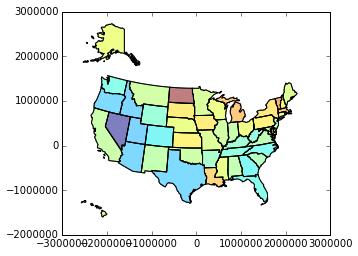

In [19]:
geo_diff = state_geo.join(state_fit_params)
geo_diff.plot(column='dec_4_loss_rate')
geo_diff.head(3)